In [4]:
import odrive
import time
import serial
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [5]:
odrv0 = odrive.find_any() # PATCH neededed !!!
print(str(odrv0.vbus_voltage))

40.890995025634766


In [6]:
# Configure Power Supply

odrv0.config.dc_bus_overvoltage_trip_level = 56 # [V]
odrv0.config.dc_bus_undervoltage_trip_level = 32 # [V]
odrv0.config.dc_max_positive_current = 7.8 # [A]
odrv0.config.dc_max_negative_current = -2 # [A]

# Motor Configuration

odrv0.axis0.config.motor.motor_type = 0 # HIGH_CURRENT
odrv0.axis0.config.motor.torque_constant = 8.27 / 100
odrv0.axis0.config.motor.pole_pairs = 20
odrv0.axis0.config.motor.current_soft_max = 50
odrv0.axis0.config.motor.current_hard_max = 70
odrv0.axis0.config.motor.calibration_current = 10
odrv0.axis0.config.motor.resistance_calib_max_voltage = 2
odrv0.axis0.config.calibration_lockin.current = 10

odrv0.axis0.requested_state = 4 # MOTOR_CALIBRATION

print(f"Phase resistance: {odrv0.axis0.config.motor.phase_resistance} Ohm")
print(f"Phase inductance: {odrv0.axis0.config.motor.phase_inductance} H")

odrv0.save_configuration() # saving the configuration

Phase resistance: 0.03332959860563278 Ohm
Phase inductance: 1.507453362137312e-05 H


False

In [7]:
# Setting the Limits

odrv0.axis0.controller.config.vel_limit = 25 # [turn/s]
odrv0.axis0.controller.config.vel_limit_tolerance = 1.8 # [turn/s]
odrv0.axis0.config.torque_soft_min = -4 # [Nm]
odrv0.axis0.config.torque_soft_max = 4 # [Nm]

# Encoder Configuration

odrv0.axis0.config.load_encoder = 13 # ONBOARD_ENCODER0
odrv0.axis0.config.commutation_encoder = 13 # ONBOARD_ENCODER0

odrv0.axis0.requested_state = 7 # ENCODER_OFFSET_CALIBRATION

In [59]:
# Setting up the control loop

odrv0.axis0.requested_state = 8 # CLOSED_LOOP_CONTROL
odrv0.axis0.controller.config.input_mode = 1 # PASSTHROUGH
odrv0.axis0.controller.config.control_mode = 3 # POSITION_CONTROL

# baselin gains
# odrv0.axis0.controller.config.pos_gain = 20.0
# odrv0.axis0.controller.config.vel_gain = 0.16
# odrv0.axis0.controller.config.vel_integrator_gain = 0.32

odrv0.axis0.controller.config.pos_gain = 20.0*1.3**4
odrv0.axis0.controller.config.vel_gain = 0.5*(0.16*1.3**9)
odrv0.axis0.controller.config.vel_integrator_gain = 0#0.32

ser = serial.Serial('COM11', 115200, timeout=0.050)

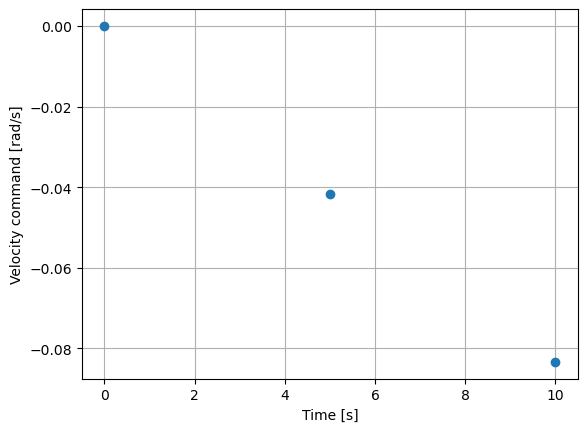

In [53]:
DesPos = np.linspace(0, -30/360, 3)
DesTime = np.linspace(0, 10, 3)

plt.figure()
plt.plot(DesTime, DesPos, 'o')
plt.xlabel('Time [s]')
plt.ylabel('Velocity command [rad/s]')
plt.grid()

In [33]:
def log_signals(startTime, startPos, Time, Pos, Vel, Trq):
    Time.append(time.time() - startTime) # time from start [s]
    Pos.append((odrv0.axis0.pos_vel_mapper.pos_rel - startPos)*2*np.pi) # rel. pos [rad]
    Vel.append(odrv0.axis0.pos_vel_mapper.vel*2*np.pi) # vel. [rad/s]
    Trq.append(odrv0.axis0.motor.torque_estimate) # estim. motor torque [Nm]
    return Time, Pos, Vel, Trq

In [60]:
startPos = odrv0.axis0.pos_vel_mapper.pos_rel
desPos = startPos - 60/360
strCommand = f"p 0 {desPos}\r"
ser.write(strCommand.encode(encoding="ascii"))

24

In [54]:
startTime = time.time()
startPos = odrv0.axis0.pos_vel_mapper.pos_rel
currTime = 0

Time = []
Pos = []
Vel = []
Trq = []

endTime = 10
sampling_freq = 1/100
samplings = np.linspace(0, endTime, num=int(endTime/sampling_freq + 1))
samp_count = 0
pos_count = 0

while currTime < endTime:
    currTime = time.time() - startTime
    if currTime > DesTime[pos_count]:
        desPos = DesPos[pos_count] + startPos
        strCommand = f"p 0 {desPos}\r"
        ser.write(strCommand.encode(encoding="ascii"))
        pos_count += 1
        pos_count = min([pos_count, 9])
        
    if currTime >= samplings[samp_count]:
        Time, Pos, Vel, Trq = log_signals(startTime, startPos, Time, Pos, Vel, Trq)
        samp_count += 1
        
strCommand = f"v 0 0\r"
ser.write(strCommand.encode(encoding="ascii"))

6

NameError: name 'DesVel' is not defined

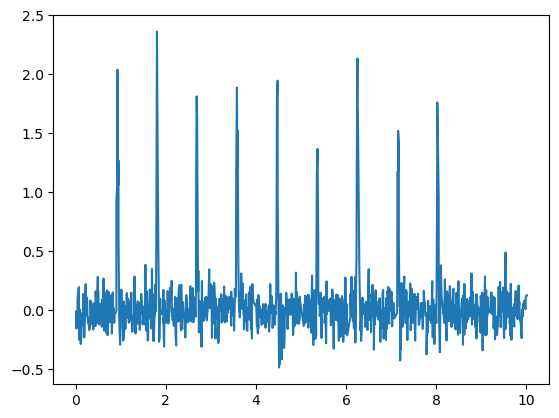

In [25]:
Timen = np.array(Time)
Posn = np.array(Pos)
Veln = np.array(Vel)
Trqn = np.array(Trq)
Data = np.column_stack((Timen, Posn, Veln, Trqn))
df = pd. DataFrame(Data)
df.to_csv('calibration.csv', index=False, header=False)

plt.figure()
plt.plot(Time, Vel)
plt.plot(DesTime, DesVel, 'o')
plt.show()

plt.figure()
plt.plot(Time, Trq)
plt.show()

In [61]:
#odrv0. clear_errors()
odrv0.axis0.requested_state = 1 # IDLE
ser.close()